In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import vgg16, inception_v3
from keras.models import Sequential, Model
from keras.layers import * 
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras import initializers, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adadelta, SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import math
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'dataset-master', 'dataset2-master']


In [53]:
# reset
K.clear_session()

K.set_image_data_format('channels_last')

# This one is to test whether Keras can see the GPUs
K.get_session().list_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1806554958703447589]

In [3]:
dict_characters = {0:'NEUTROPHIL', 1:'EOSINOPHIL', 2:'MONOCYTE', 3:'LYMPHOCYTE'}
dict_characters2 = {0:'Polynuclear', 1:'Mononuclear'}

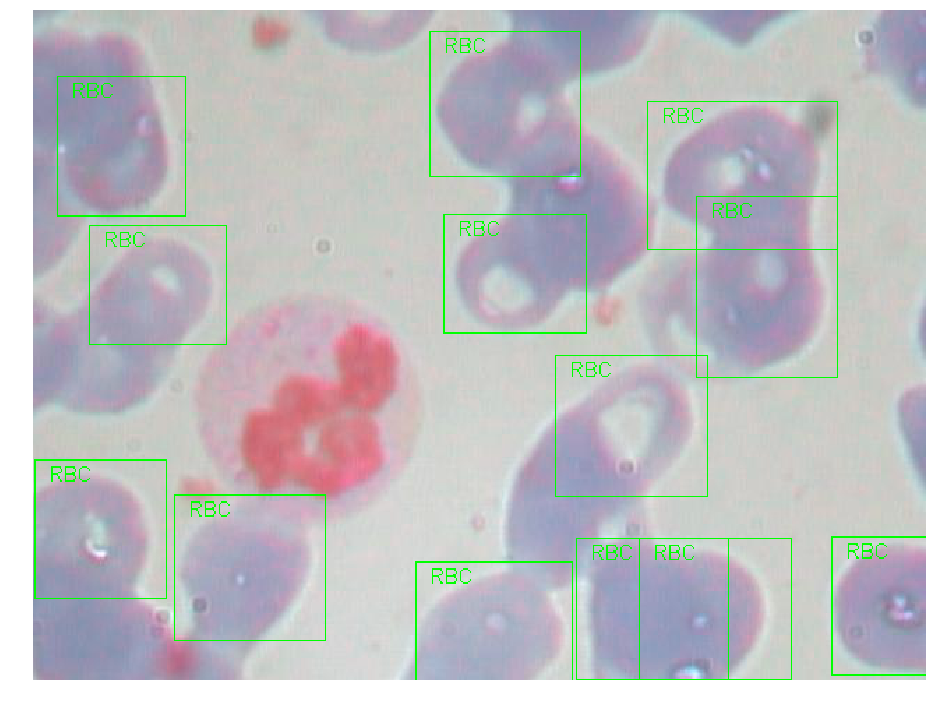

In [4]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("../input/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("../input/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.axis('off') 
plt.show()

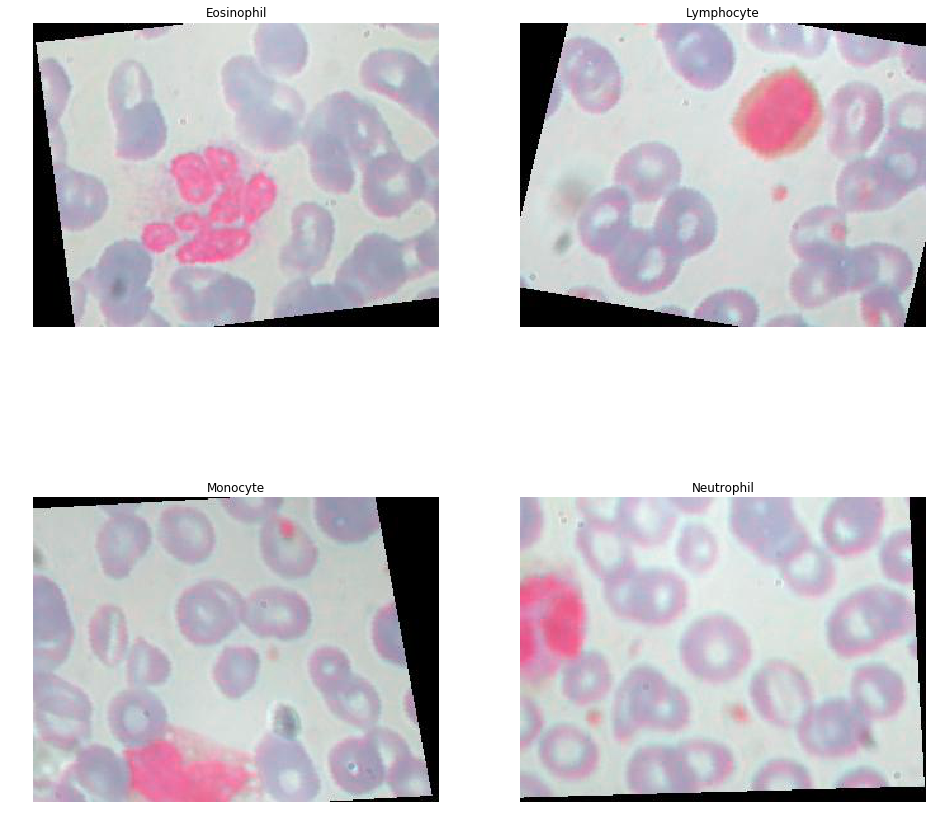

In [5]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

In [6]:
def replaceBlackBackground(image, colour):
    image_data = np.array(image)
    red, green, blue = image_data.T
    # Replace black with color...
    black_areas = (red < 60) & (blue < 60) & (green < 60)
    image_data[black_areas.T] = colour
    return Image.fromarray(image_data)

new_background_colour = (210, 215, 213)

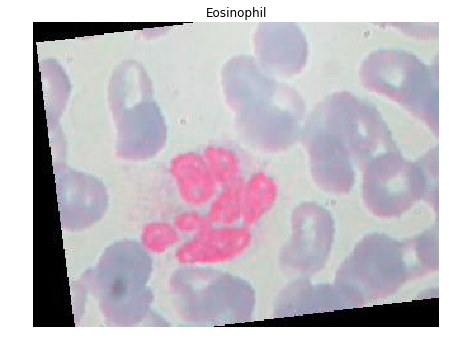

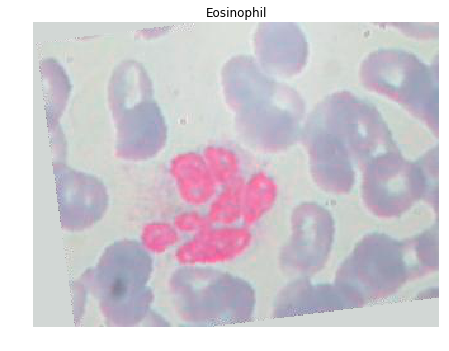

In [7]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    image2 = replaceBlackBackground(image, colour=new_background_colour)
    plt.figure(figsize=(16,16))
    plt.subplot(121)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image)
    plt.figure(figsize=(16,16))
    plt.subplot(122)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image2)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plotImage(image_name)

[  3  88  33  21 207]


Text(0,0.5,'Counts')

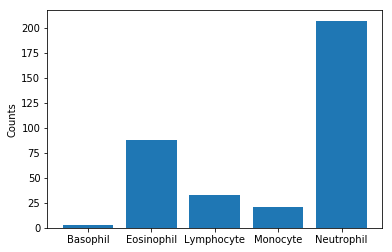

In [8]:
reader = csv.reader(open('../input/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

In [9]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 0
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 0
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 1
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3
                label2 = 1
            # else:
            #     label = 4
            #     label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = replaceBlackBackground(img_file, new_background_colour)
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

  0%|          | 0/2499 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 620/620 [00:01<00:00, 401.83it/s]


In [10]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}


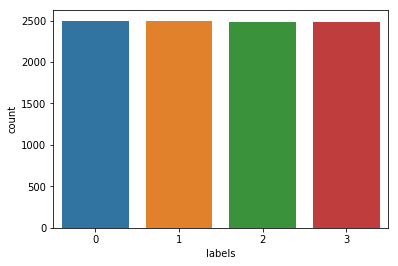

In [11]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

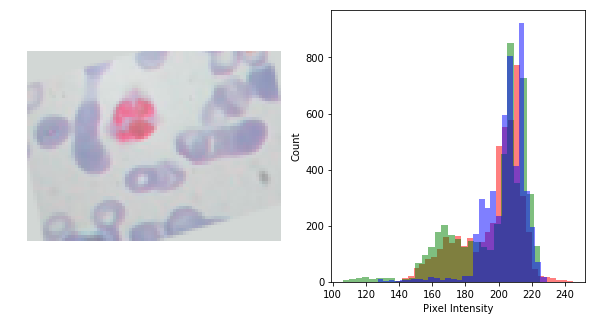

In [12]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[5])

In [13]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

In [14]:
# Helper Functions  Learning Curves and Confusion Matrix

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [15]:
X_train.shape

(9957, 60, 80, 3)

In [31]:
img_rows, img_cols, img_num_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
input_shape = (img_rows, img_cols, img_num_channels)
num_classes = len(y_trainHot[0])
print("input shape:", input_shape)
print("num classes:", num_classes)

input shape: (60, 80, 3)
num classes: 4


In [60]:
def build_keras_model(model_name, num_classes, input_shape):
    if model_name == 'vgg16':
        base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif name=='inception_v3':
        base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:        
        return
    
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(num_classes, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False
        
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    
    return model

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, learning_rate=0.001, lr_decay=0.9,
                metrics=['accuracy'], batch_size=100, epochs=30, shift_fraction=0.1, save_dir='./result'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """

    # callbacks
    checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay_callback = callbacks.LearningRateScheduler(schedule=lambda epoch: learning_rate * (lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=Adam(lr=learning_rate), loss=['categorical_crossentropy'], metrics=['accuracy'])

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[checkpoint, lr_decay_callback])
    """
    
    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
            train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=shift_fraction, # randomly shift images horizontally (fraction of total width)
            height_shift_range=shift_fraction, # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False  # randomly flip images
        )  
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    history = model.fit_generator(
        generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
        epochs=args.epochs,
        validation_data=[[x_test, y_test], [y_test, x_test]],
        callbacks=[checkpoint, lr_decay_callback]
    )
    # End: Training with data augmentation -----------------------------------------------------------------------#
    
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

    from utils import plot_log
    plot_log(save_dir + '/log.csv', show=True)

    return history

In [ ]:
def test_model(model, x_test, y_test, history, args):
    score = model.evaluate(x_test, y_test, verbose=True)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

In [ ]:
def runVgg16(x_train, y_train, x_test, y_test):
    
    epochs = 30
    batch_size = 100
    learning_rate = 0.001 
    lr_decay = 0.9
    shift_fraction = 0.1
    save_dir = './result'
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, shift_fraction=0.1, save_dir='./result')
    test_model(model, x_test, y_test, history, args)
    
runCapsNet(X_train, y_trainHot, X_test, y_testHot)